In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sqlalchemy import create_engine


In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
heartdisease_df = pd.read_sql_query('select * from heartdisease',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [3]:
# Define the features and the outcome
X = heartdisease_df.iloc[:, :13]
y = heartdisease_df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis
y = np.where(y > 0, 0, 1)

In [4]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Computing the first principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=1)

In [6]:
# Make sure the number of rows divides evenly into four samples.
rows = heartdisease_df.shape[0] - heartdisease_df.shape[0] % 2
df = heartdisease_df.iloc[:rows, :]

# Break into a set of features and a variable for the known outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace some random string values.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

# Normalize
X_std = StandardScaler().fit_transform(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=123)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

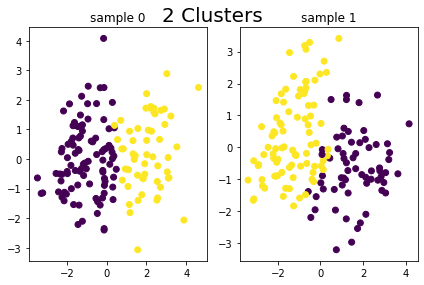

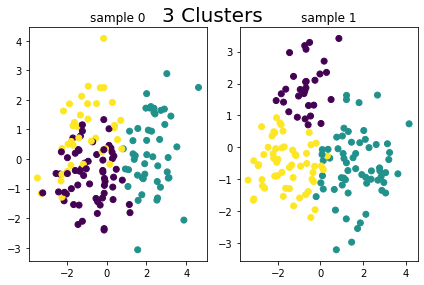

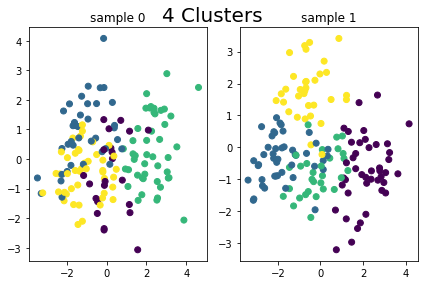

In [7]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
        axarr[i].set_xlim()
        axarr[i].set_ylim()
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

In [8]:
# Get predicted clusters.
full_pred = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)

pd.crosstab(y, full_pred) 

col_0,0,1
row_0,,
0,101,38
1,13,150


In [9]:
metrics.adjusted_rand_score(y, full_pred)

0.43661540614807665

In [10]:

pred_2 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
pred_3 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
pred_4 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

print("ARI for two cluster k-means: {}".format(
    metrics.adjusted_rand_score(y, pred_2)))
print("ARI for three cluster k-means: {}".format(
    metrics.adjusted_rand_score(y, pred_3)))
print("ARI for four cluster k-means: {}".format(
    metrics.adjusted_rand_score(y, pred_4)))

ARI for two cluster k-means: 0.43661540614807665
ARI for three cluster k-means: 0.280694132678885
ARI for four cluster k-means: 0.1968993286830863


In [11]:
labels = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
print('silhouette score 2 cluster k-means: {}'.format(
    metrics.silhouette_score(X_std, labels, metric='euclidean')))

labels = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
print('silhouette score 3 cluster k-means: {}'.format(
    metrics.silhouette_score(X_std, labels, metric='euclidean')))

labels = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)
print('silhouette score 4 cluster k-means: {}'.format(
    metrics.silhouette_score(X_std, labels, metric='euclidean')))

silhouette score 2 cluster k-means: 0.17440650461256255
silhouette score 3 cluster k-means: 0.12862190702187828
silhouette score 4 cluster k-means: 0.13186062012858554


## According to the solutions the two cluster solution is best for both the ARI and Silhouette scores for k-means clustering

## Produce dendrograms for the heart disease dataset using three different linkage methods: complete, average and ward. Which linkage method do you think produces more reasonable result?

In [13]:
from sklearn.cluster import AgglomerativeClustering

## Complete agglomerative clustering

In [24]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

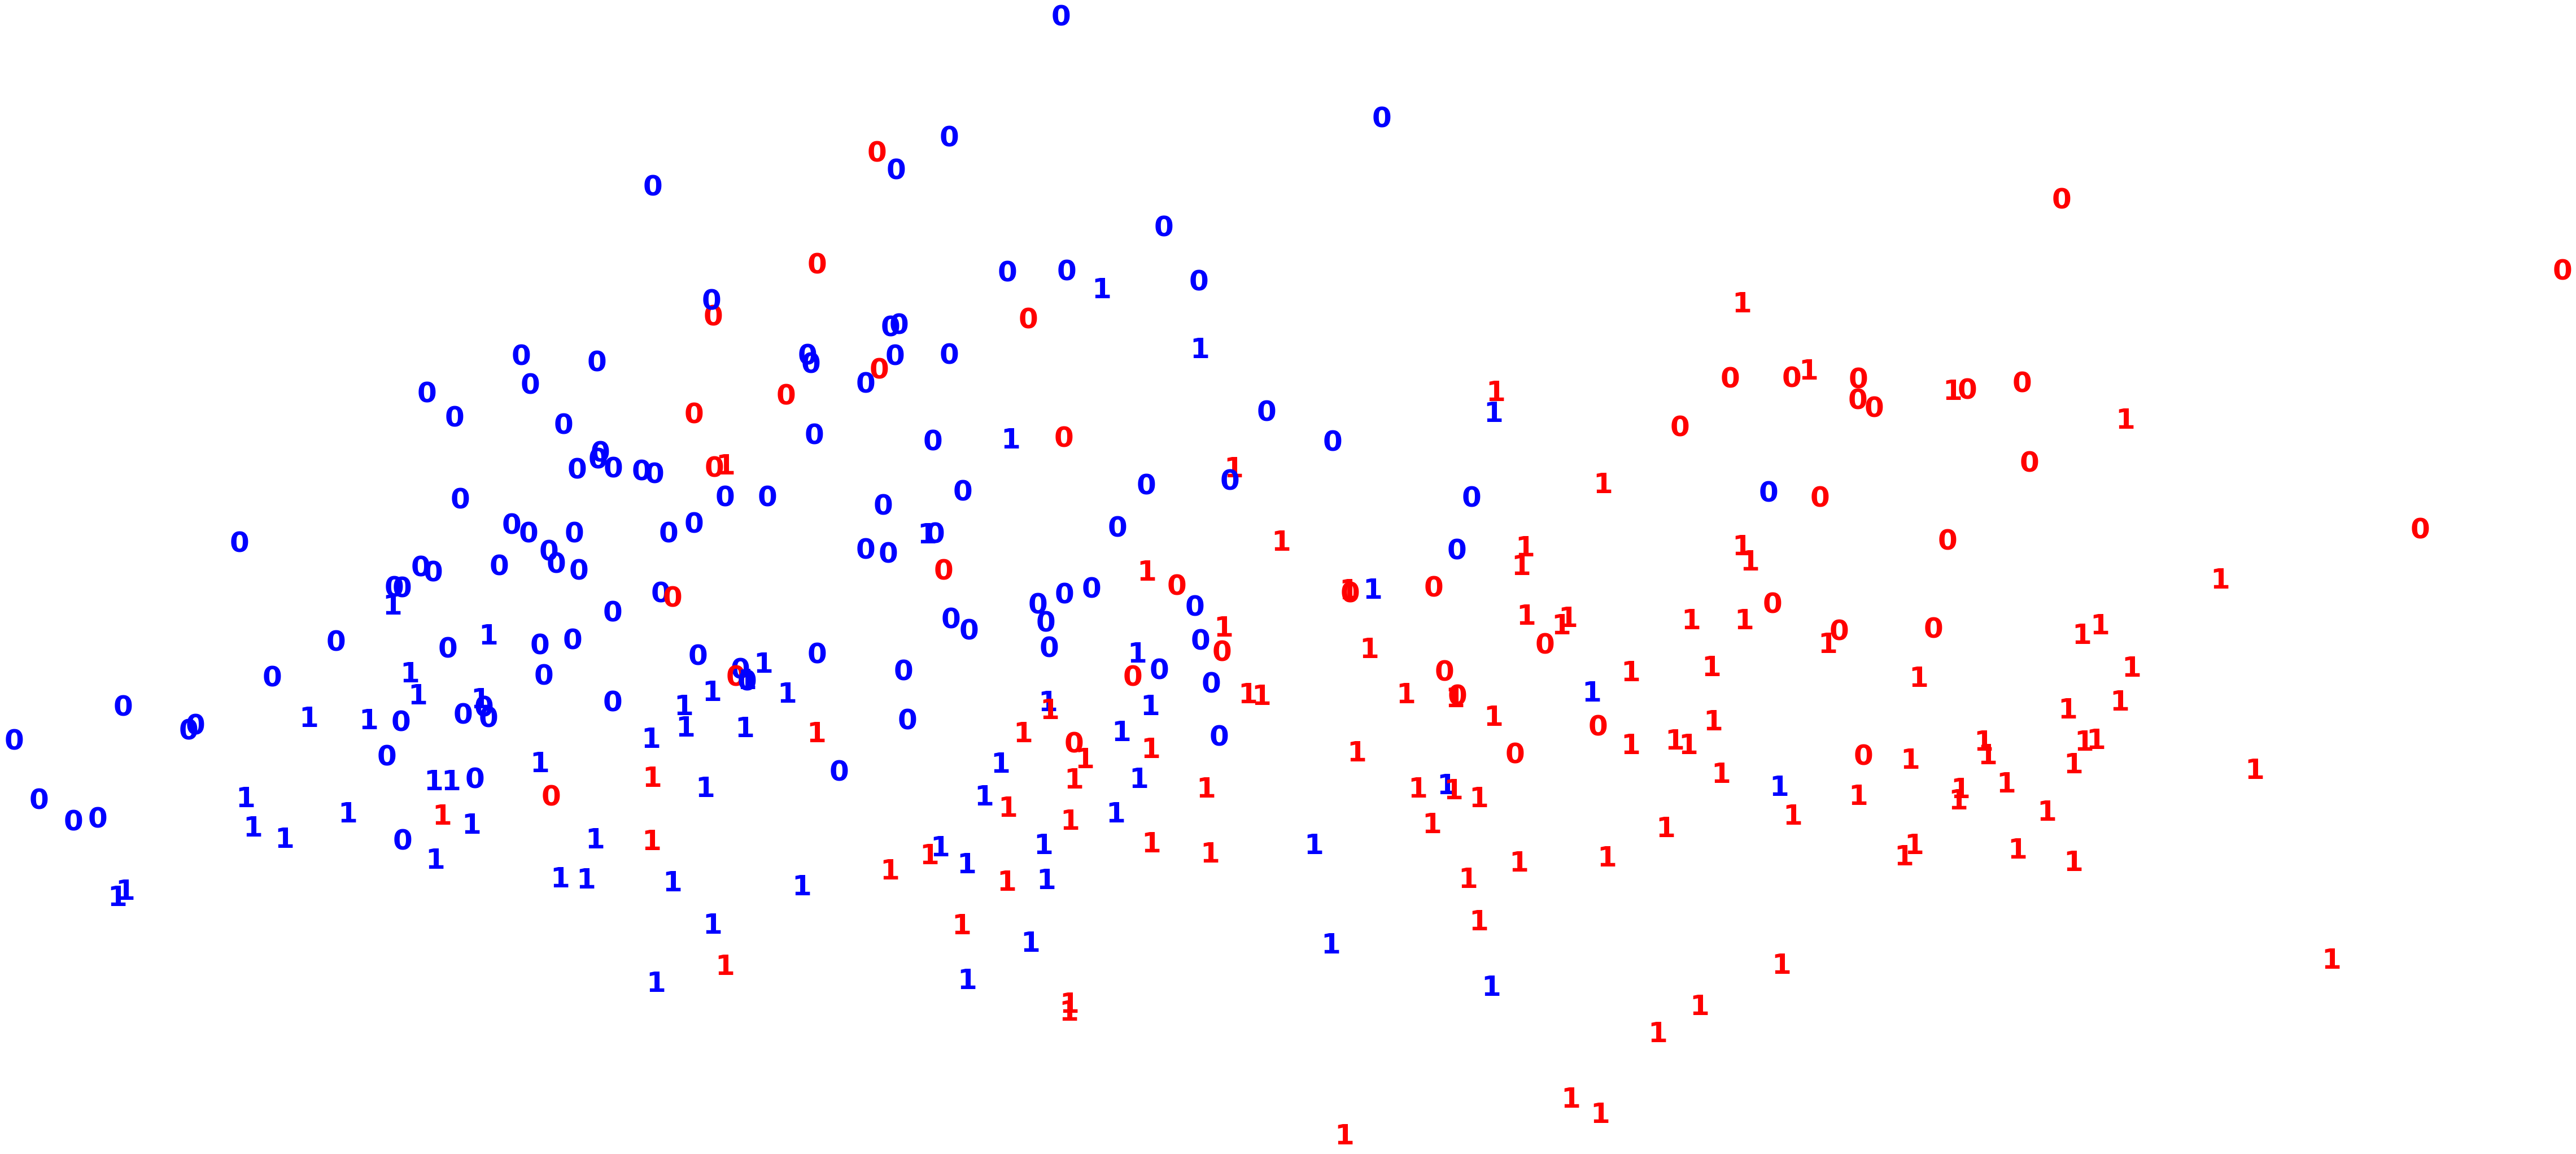

In [25]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [26]:
print("Adjusted Rand Index of the Agglomerative Clustering solution (complete): {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the Agglomerative Clustering solution (complete): {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Adjusted Rand Index of the Agglomerative Clustering solution (complete): 0.10233468474116167
The silhoutte score of the Agglomerative Clustering solution (complete): 0.07445588349053094


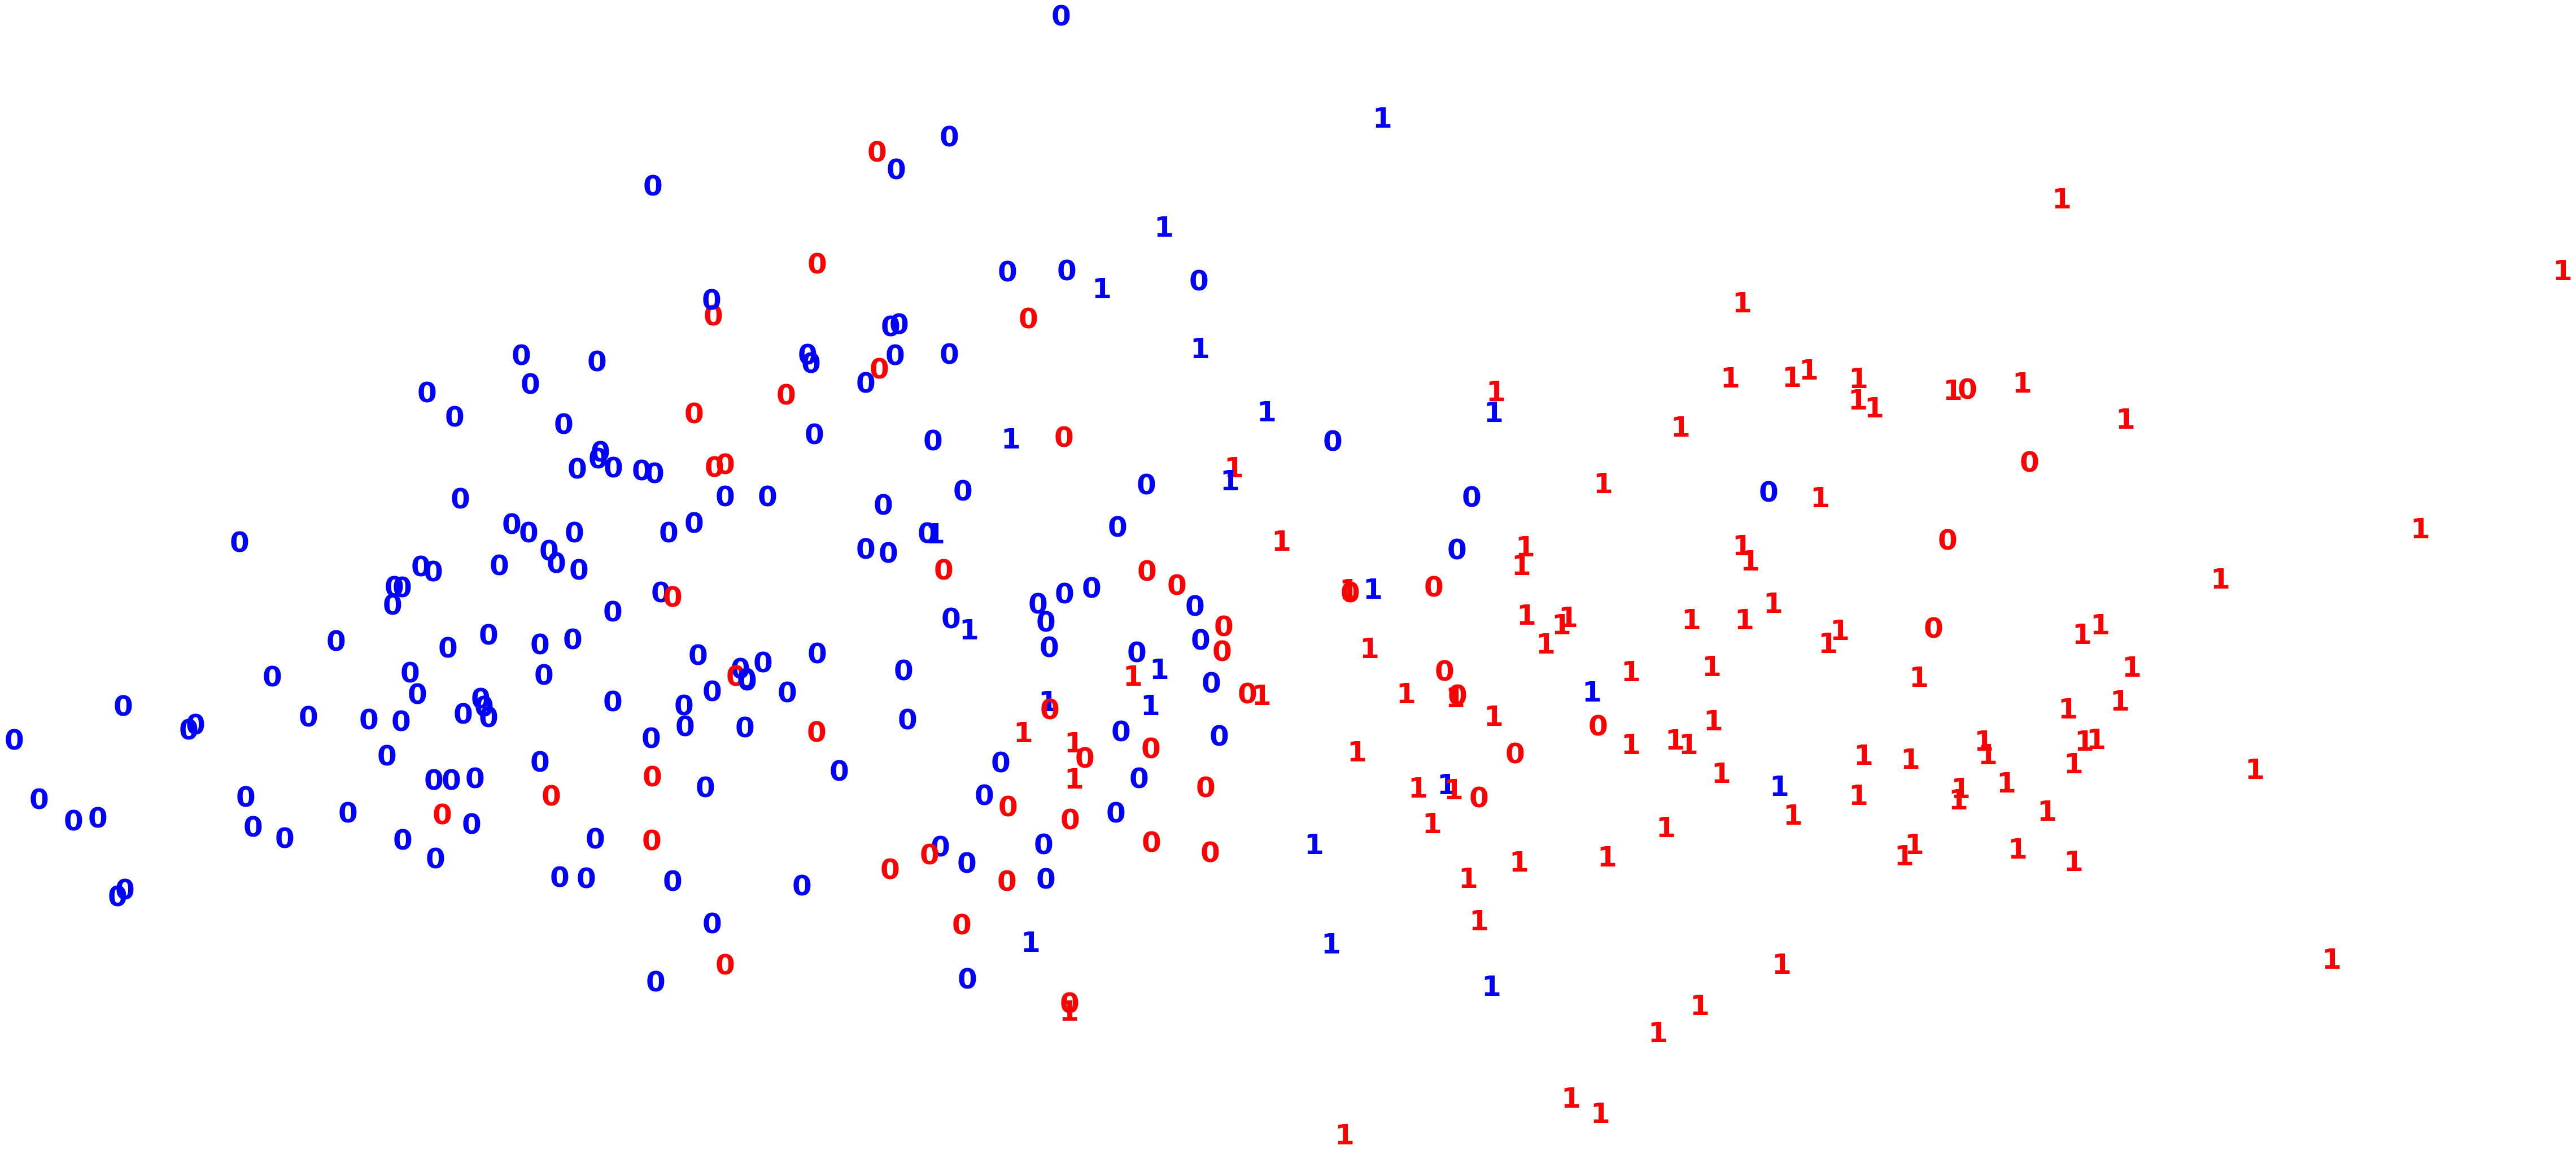

Adjusted Rand Index of the Agglomerative Clustering solution (average): 0.29242115793299467
The silhoutte score of the Agglomerative Clustering solution (average): 0.14746387683622914


In [27]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

#visualize results
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

#print the ARI and Silhouette scores
print("Adjusted Rand Index of the Agglomerative Clustering solution (average): {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the Agglomerative Clustering solution (average): {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

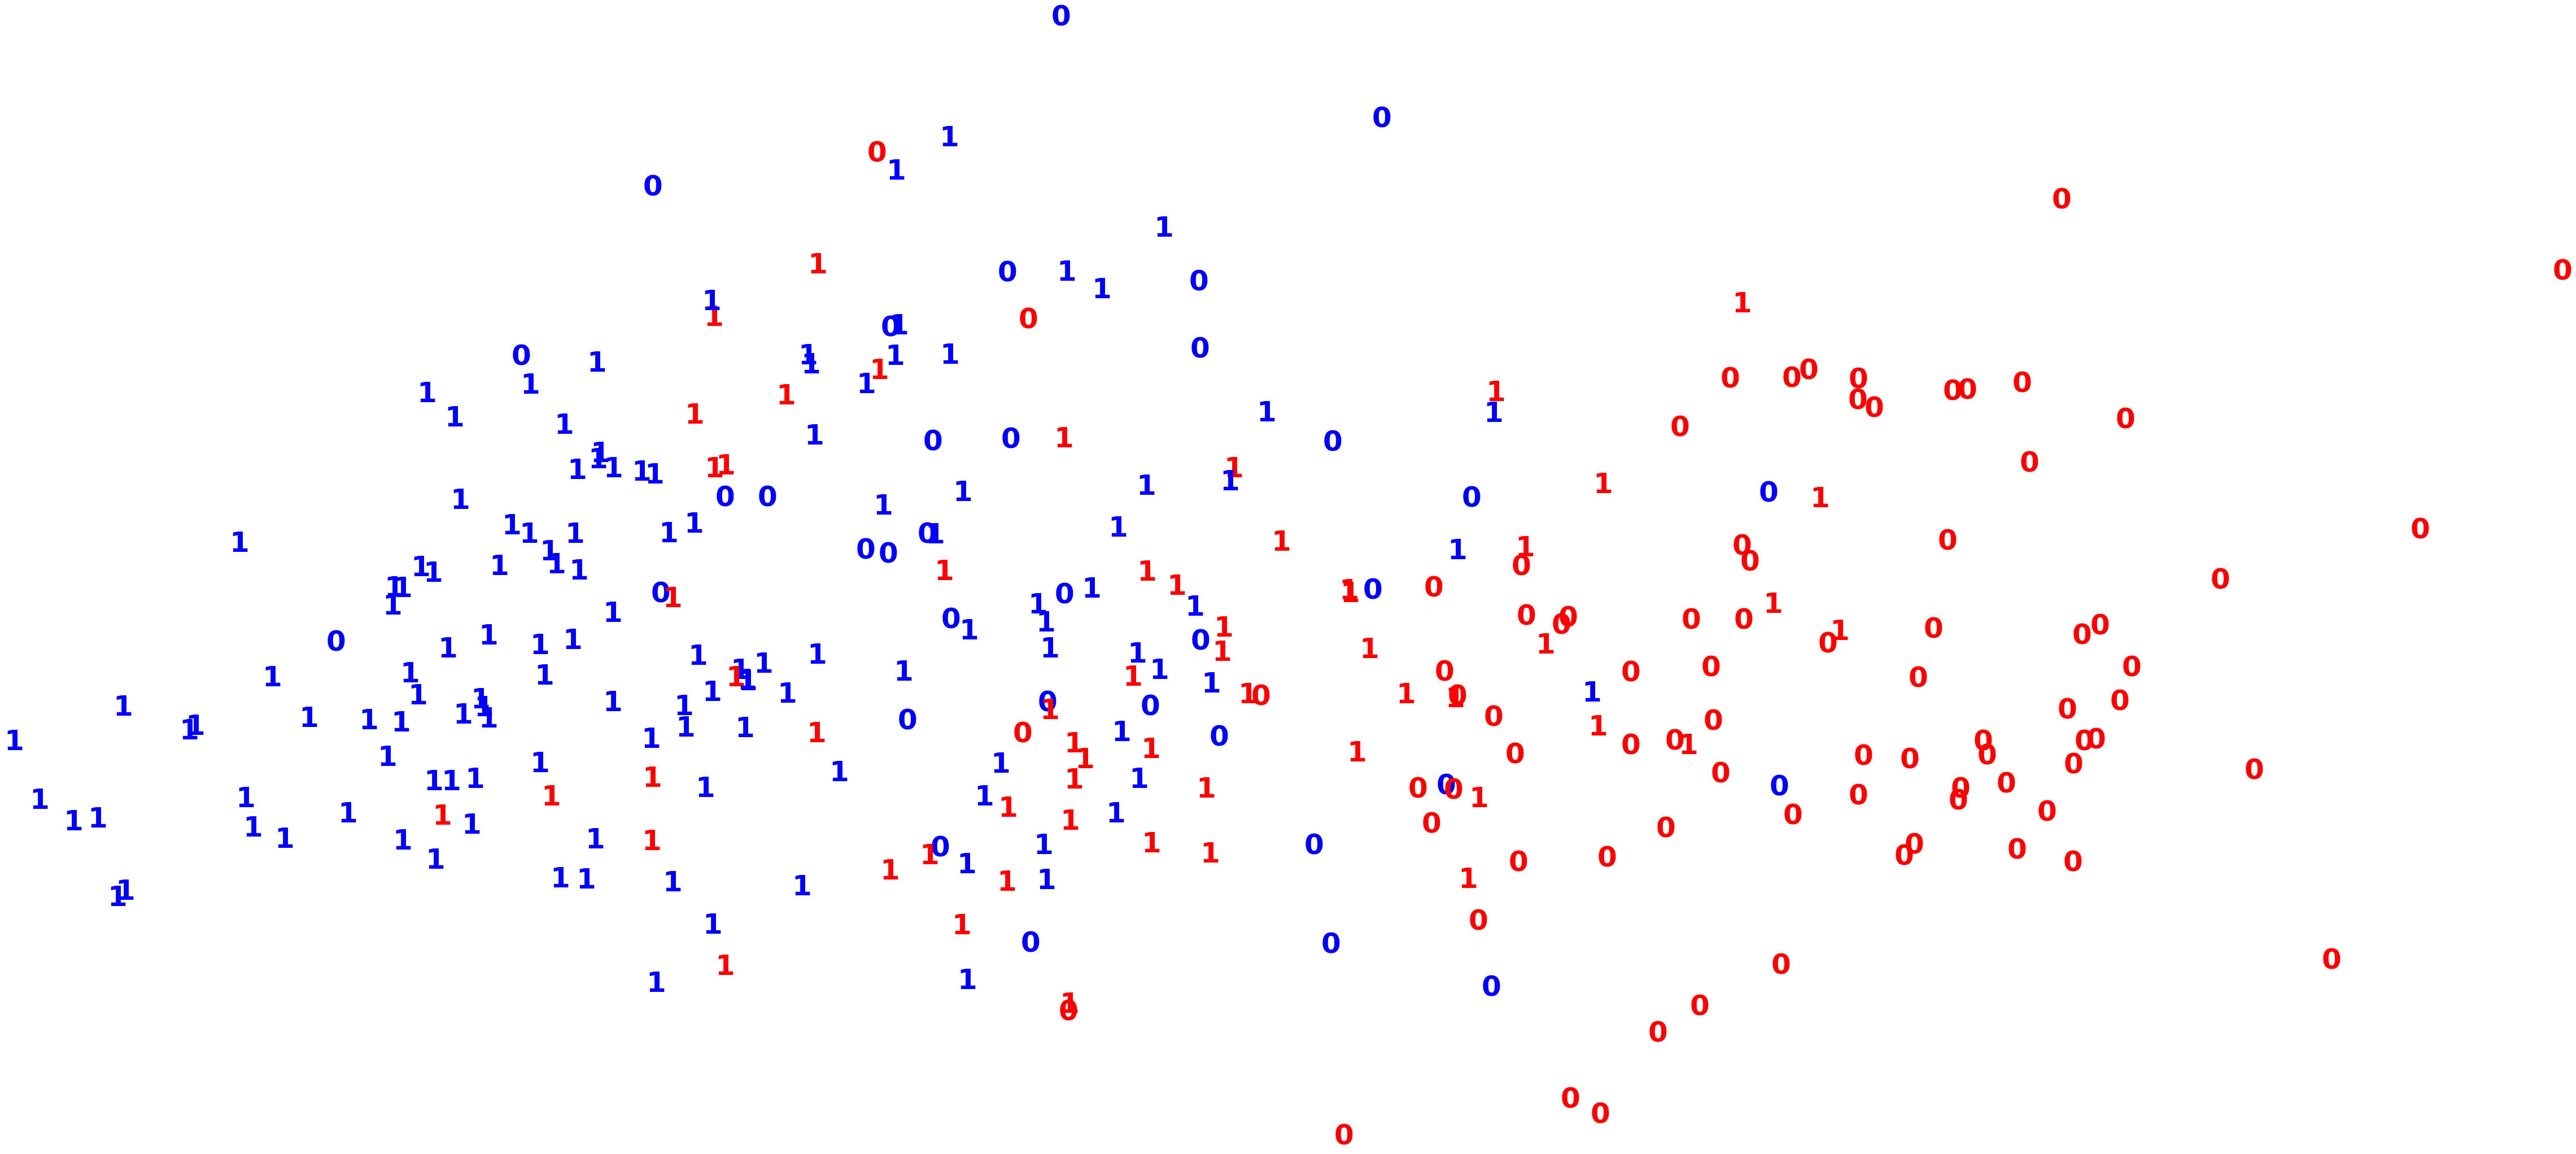

Adjusted Rand Index of the Agglomerative Clustering solution (ward): 0.14457486386986915
The silhoutte score of the Agglomerative Clustering solution (ward): 0.1377396413078055


In [28]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

#visualize results
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

#print the ARI and Silhouette scores
print("Adjusted Rand Index of the Agglomerative Clustering solution (ward): {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the Agglomerative Clustering solution (ward): {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

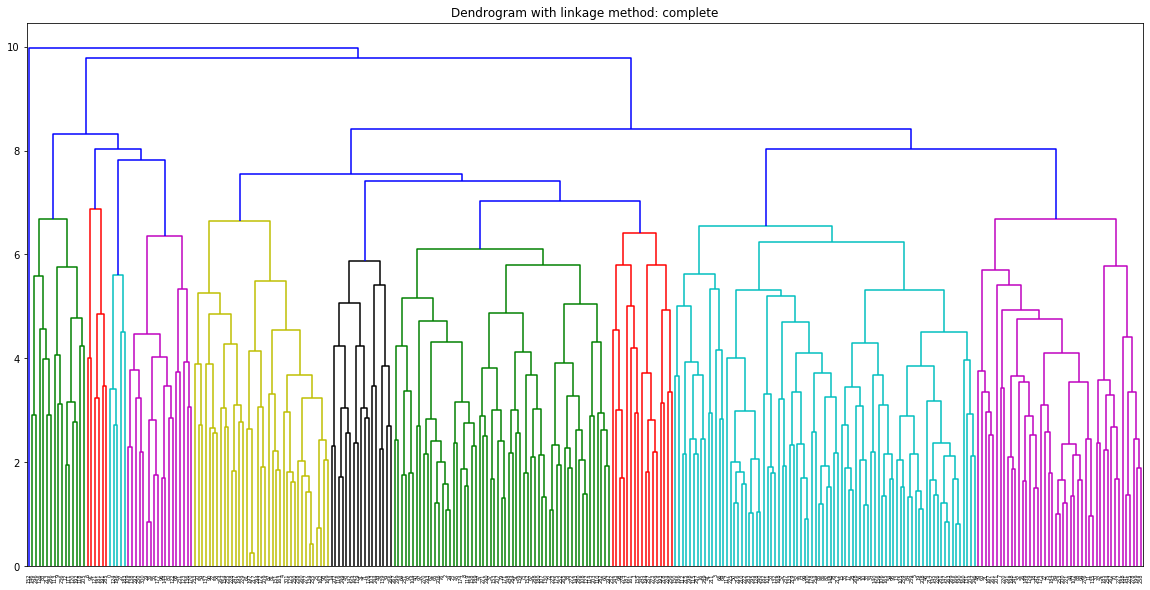

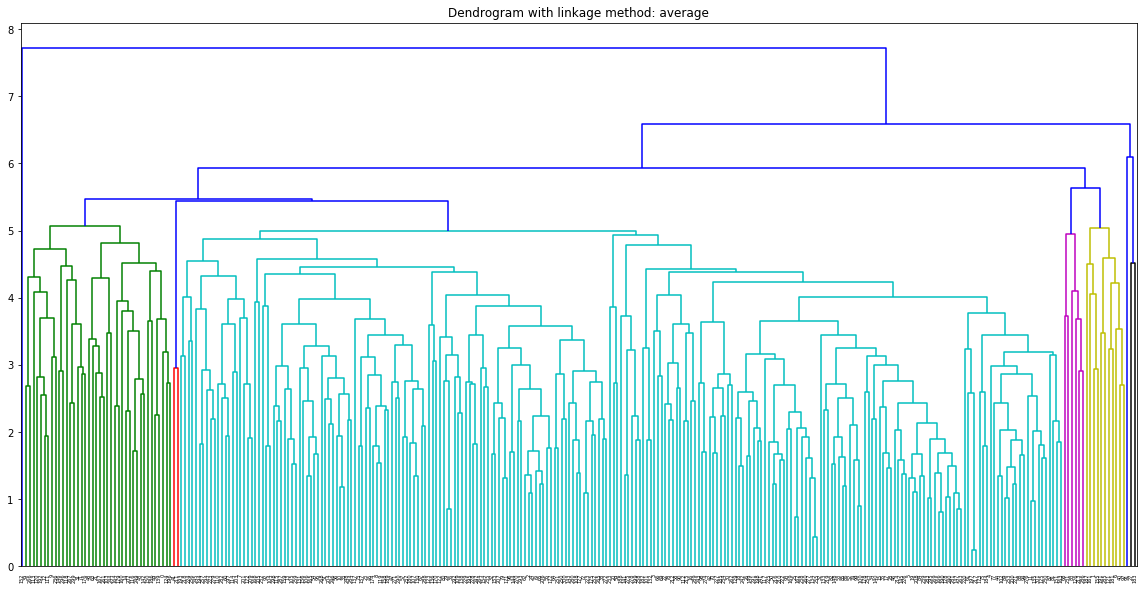

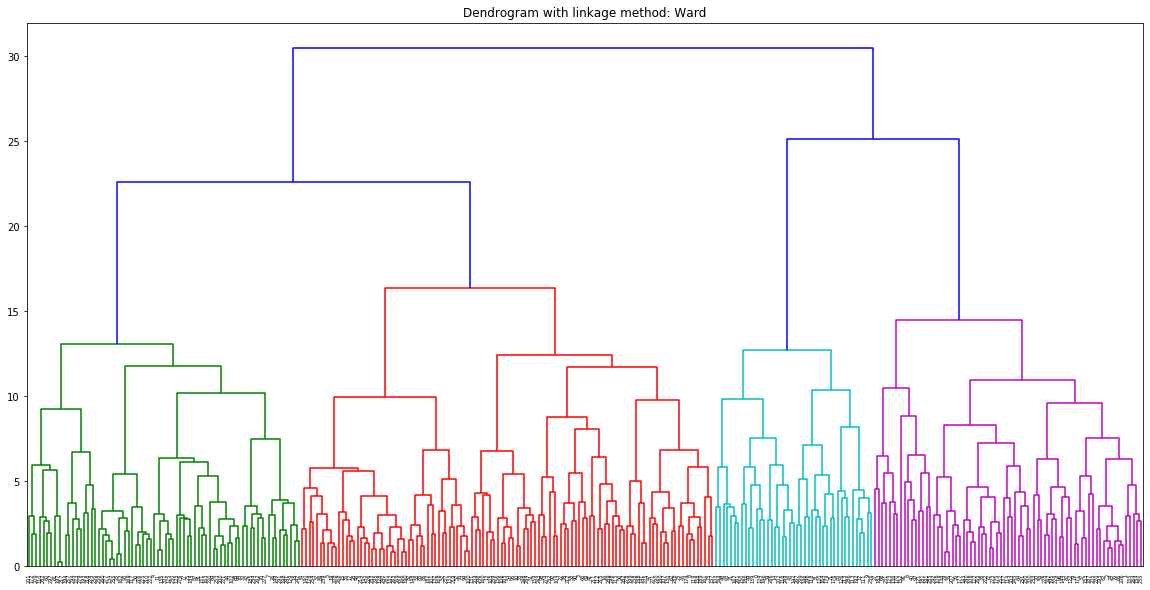

In [30]:
#visualize dendrograms
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: complete")
dendrogram(linkage(X_std, method='complete'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: average")
dendrogram(linkage(X_std, method='average'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram with linkage method: Ward")
dendrogram(linkage(X_std, method='ward'))
plt.show()

## looking at the dendrograms the only one that looks right is the ward solution. The other answers have too few observations in one of the clusters. But when looking at the ARI and Silhouette scores, the average method performs best. But when looking back, the k-means score definitely out-performs the agglomerative clustering

## DBSCAN
## Apply DBSCAN to the heart disease data by trying different values for eps and min_samples parameters. You'll realize that it's really hard to get a two cluster solution using DBSCAN if not impossible.

In [31]:
from sklearn.cluster import DBSCAN

In [36]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=1)

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

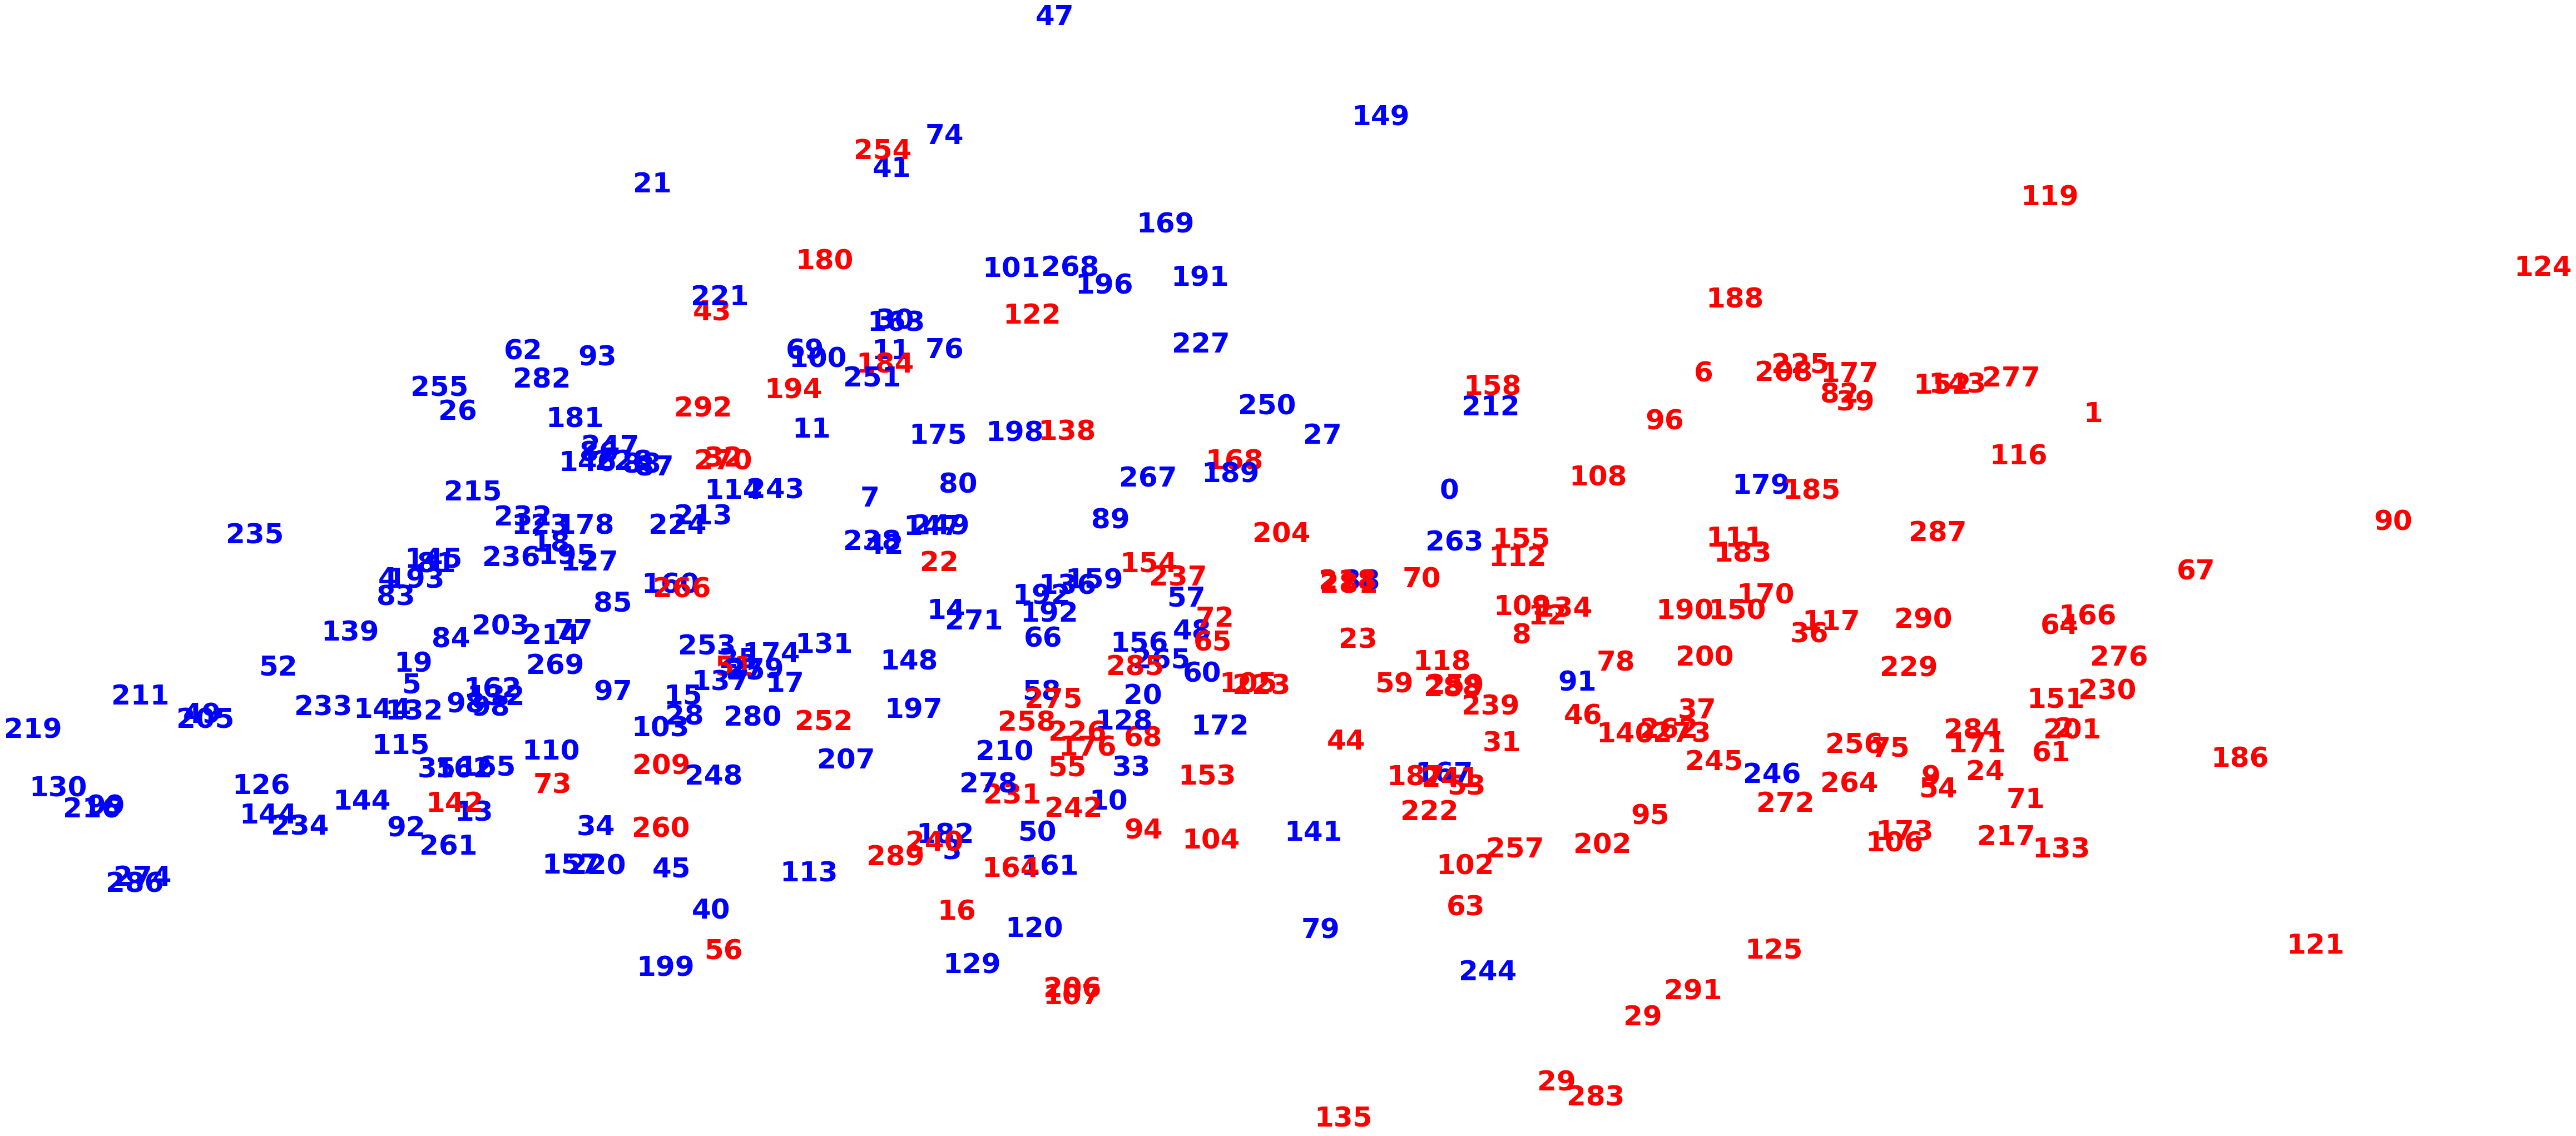

In [37]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## Apply DBSCAN by setting parameters eps=1, min_samples=1, metric="euclidean". Then, increase the value of min_samples. What's the effect of increasing min_samples on the number of clusters DBSCAN identifies?

In [38]:
dbscan_cluster = DBSCAN(eps=1, min_samples=1, metric="euclidean")

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

print("Number of clusters when min_samples=1 is: {}".format(len(np.unique(clusters))))

min_samples_list = range(2,51)

for i in range(2,51):
    dbscan_cluster = DBSCAN(eps=1, min_samples=i, metric="euclidean")
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    print("Number of clusters when min_samples={} is: {}".format(i, len(np.unique(clusters))))

Number of clusters when min_samples=1 is: 293
Number of clusters when min_samples=2 is: 9
Number of clusters when min_samples=3 is: 2
Number of clusters when min_samples=4 is: 1
Number of clusters when min_samples=5 is: 1
Number of clusters when min_samples=6 is: 1
Number of clusters when min_samples=7 is: 1
Number of clusters when min_samples=8 is: 1
Number of clusters when min_samples=9 is: 1
Number of clusters when min_samples=10 is: 1
Number of clusters when min_samples=11 is: 1
Number of clusters when min_samples=12 is: 1
Number of clusters when min_samples=13 is: 1
Number of clusters when min_samples=14 is: 1
Number of clusters when min_samples=15 is: 1
Number of clusters when min_samples=16 is: 1
Number of clusters when min_samples=17 is: 1
Number of clusters when min_samples=18 is: 1
Number of clusters when min_samples=19 is: 1
Number of clusters when min_samples=20 is: 1
Number of clusters when min_samples=21 is: 1
Number of clusters when min_samples=22 is: 1
Number of cluster

## Apply DBSCAN by setting parameters eps=1, min_samples=1, metric="euclidean". Then, increase the value of eps. What's the effect of increasing eps on the number of clusters DBSCAN identifies?


In [39]:
dbscan_cluster = DBSCAN(eps=1, min_samples=1, metric="euclidean")

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

print("Number of clusters when eps=1 is: {}".format(len(np.unique(clusters))))

min_samples_list = range(2,51)

for i in [0.01,0.1,1,2,3,4,5,6,7,8,9,10]:
    dbscan_cluster = DBSCAN(eps=i, min_samples=1, metric="euclidean")
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    print("Number of clusters when eps={} is: {}".format(i, len(np.unique(clusters))))

Number of clusters when eps=1 is: 293
Number of clusters when eps=0.01 is: 302
Number of clusters when eps=0.1 is: 302
Number of clusters when eps=1 is: 293
Number of clusters when eps=2 is: 178
Number of clusters when eps=3 is: 35
Number of clusters when eps=4 is: 3
Number of clusters when eps=5 is: 1
Number of clusters when eps=6 is: 1
Number of clusters when eps=7 is: 1
Number of clusters when eps=8 is: 1
Number of clusters when eps=9 is: 1
Number of clusters when eps=10 is: 1


## Gaussian Mixture

## Apply GMM to the heart disease data by setting n_components=2. Get ARI and silhouette scores for your solution and compare it with those of the k-means and hierarchical clustering solutions that you implemented in the assignments of the previous checkpoints. Which algorithm does perform better?

In [40]:
from sklearn.mixture import GaussianMixture

In [41]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

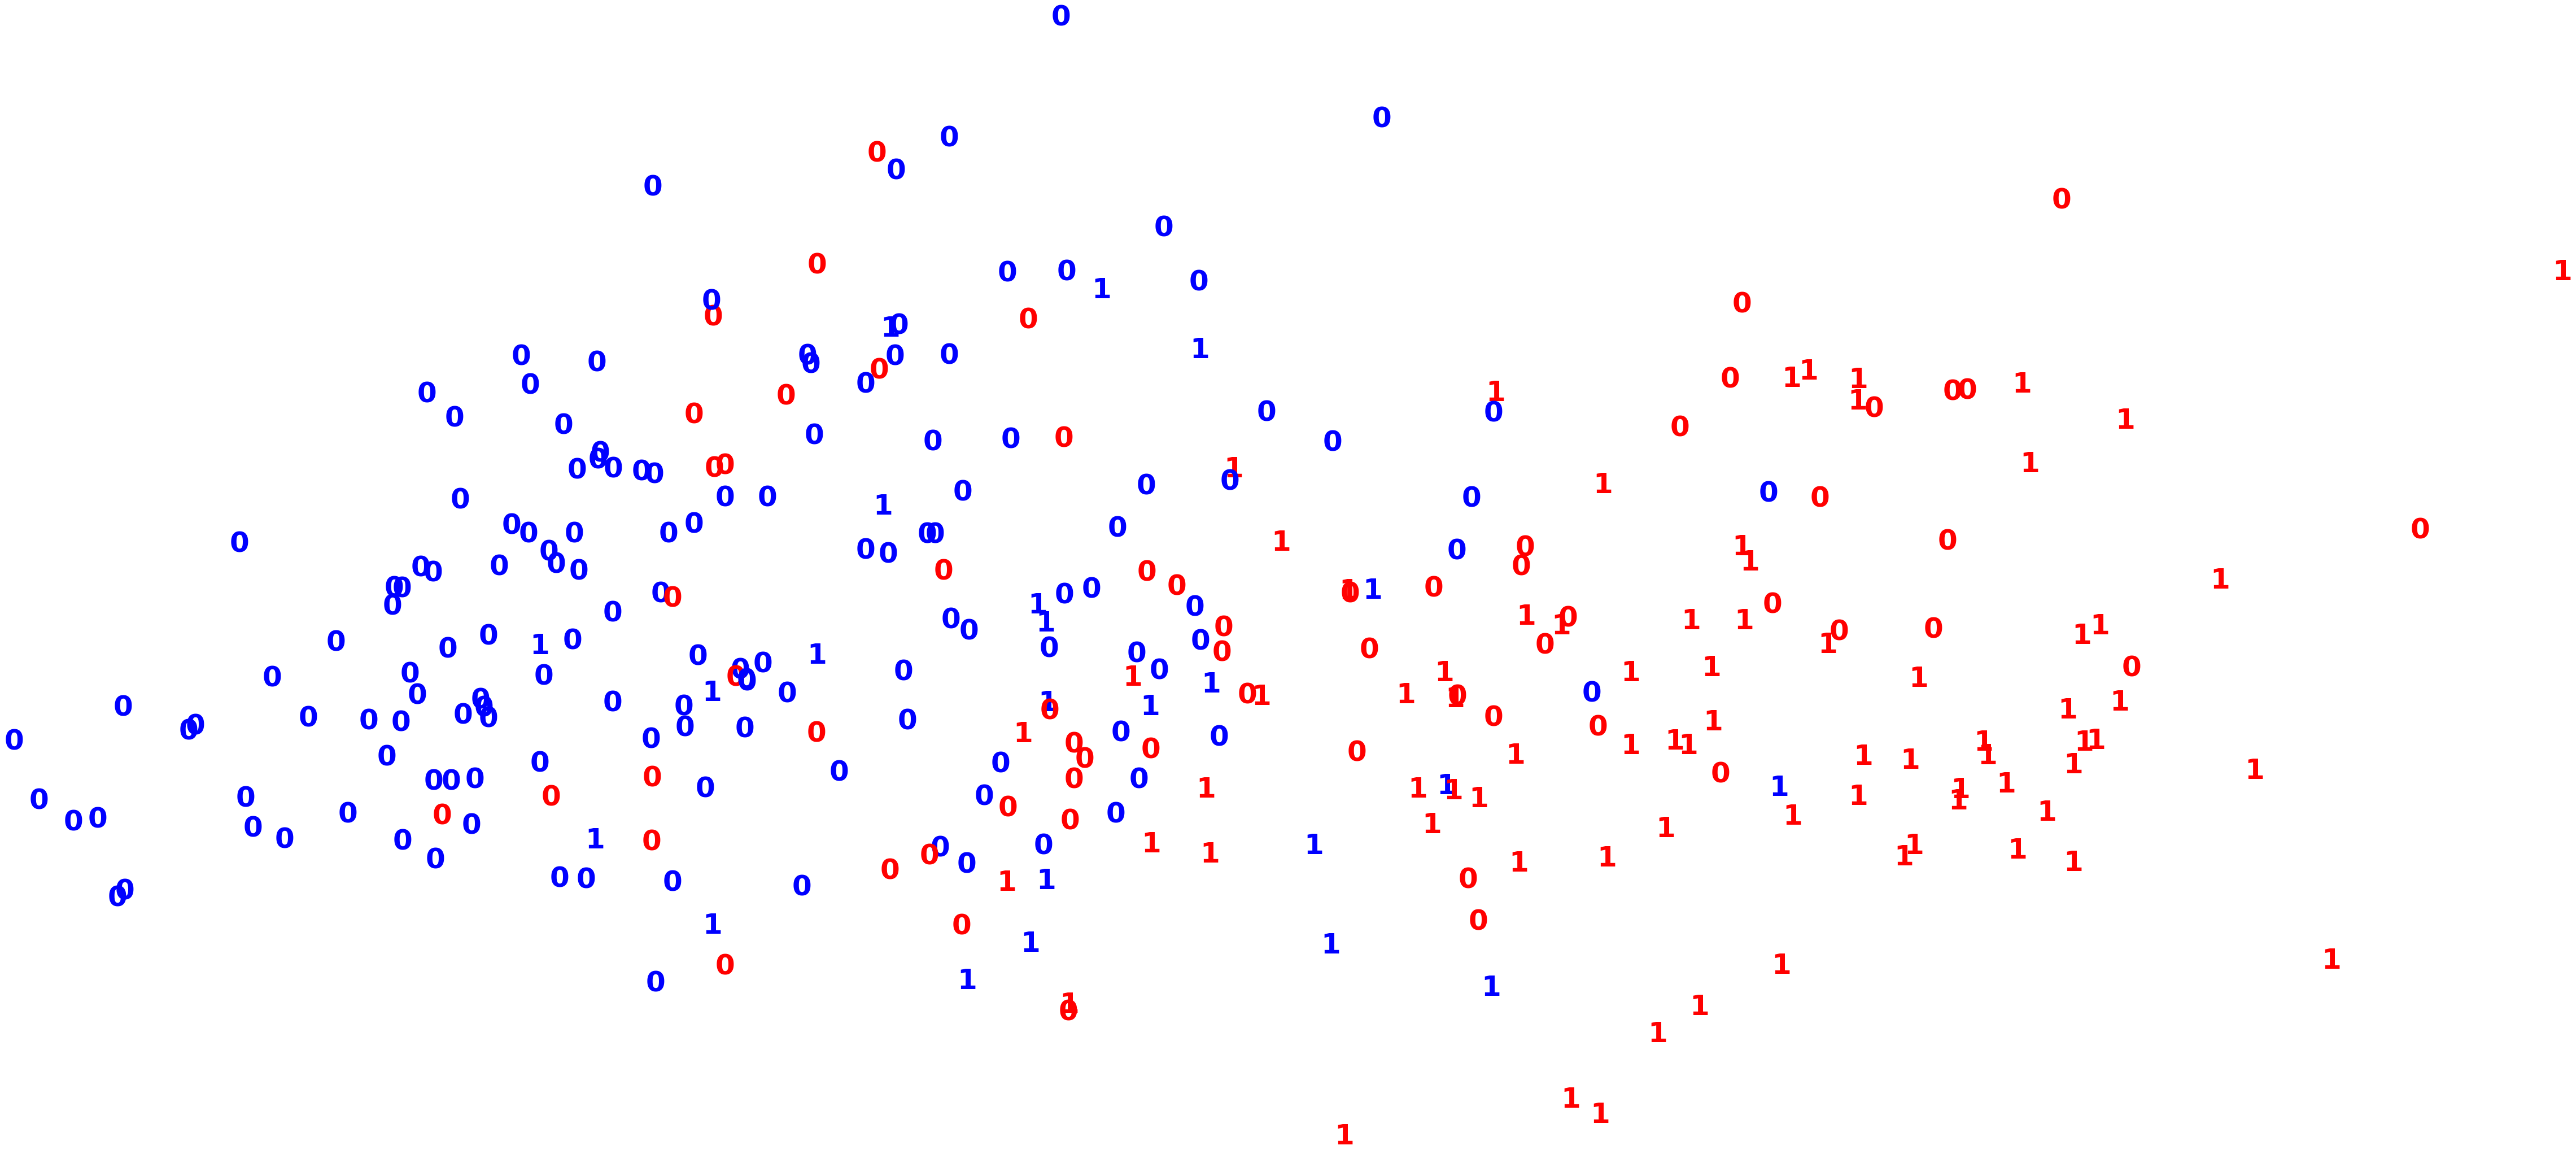

In [42]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [43]:
print("Adjusted Rand Index of the GMM solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the GMM solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Adjusted Rand Index of the GMM solution: 0.18230716541111341
The silhoutte score of the GMM solution: 0.13560123273712887


## GMM implementation of scikit-learn has a parameter called covariance_type. This parameter determines the type of covariance parameters to use. Specifically, there are four types you can specify:

full: This is the default. Each component has its own general covariance matrix.

tied: All components share the same general covariance matrix.

diag: Each component has its own diagonal covariance matrix.

spherical: Each component has its own single variance.

Try all of these. Which one does perform better in terms of ARI and silhouette scores?

In [45]:
# Defining the agglomerative clustering full
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type='full')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

print("ARI score with covariance_type=full: {}".format(
    metrics.adjusted_rand_score(y, clusters)))

print("Silhouette score with covariance_type=full: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))

print('-' * 90)

# Defining the agglomerative clustering tied
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type='diag')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

print("ARI score with covariance_type=diag: {}".format(
    metrics.adjusted_rand_score(y, clusters)))

print("Silhouette score with covariance_type=diag: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))

print('-' * 90)

# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type='tied')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

print("ARI score with covariance_type=tied: {}".format(
    metrics.adjusted_rand_score(y, clusters)))

print("Silhouette score with covariance_type=tied: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))

print('-' * 90)

# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123, covariance_type='spherical')

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

print("ARI score with covariance_type=spherical: {}".format(
    metrics.adjusted_rand_score(y, clusters)))

print("Silhouette score with covariance_type=spherical: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))

print('-' * 90)

ARI score with covariance_type=full: 0.18230716541111341
Silhouette score with covariance_type=full: 0.13560123273712887
------------------------------------------------------------------------------------------
ARI score with covariance_type=diag: 0.18230716541111341
Silhouette score with covariance_type=diag: 0.13560123273712887
------------------------------------------------------------------------------------------
ARI score with covariance_type=tied: 0.18230716541111341
Silhouette score with covariance_type=tied: 0.13560123273712887
------------------------------------------------------------------------------------------
ARI score with covariance_type=spherical: 0.2060175349560907
Silhouette score with covariance_type=spherical: 0.12345483213377387
------------------------------------------------------------------------------------------


## ARI is higher for spherical and Silhouette is lower than the other 3.